# Imports and Configs

In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.utils import check_array
from sklearn.ensemble import (
    StackingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_FOLDS = 10
TARGET = 'Target'

# Loading and Processing the Datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [4]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e6-eda-which-makes-sense
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


for col in cat_features:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [5]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Defining Training and Cross Validation Functions

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')

        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        oof_preds = np.zeros(X.shape[0])
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)

            y_pred_probs = model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)

            oof_pred_probs[val_idx] = y_pred_probs
            oof_preds[val_idx] = y_pred

            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)

            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')

        print(f'\n------ Accuracy: {np.mean(accs):.6f} ± {np.std(accs):.6f}')
        print(f'------ AUC:      {np.mean(aucs):.6f} ± {np.std(aucs):.6f}\n\n')

        return oof_pred_probs, oof_preds, accs, aucs
    
    def fit_predict_proba(self, X, y, X_test):            
        model = clone(self.model)
        model.fit(X, y)
        return model.predict_proba(X_test)

In [8]:
xgb_params = {
    'n_jobs': -1,
    'max_bin': 86,
    'verbosity': 0,
    'max_depth': 5,
    'max_leaves': 64,
    'booster': 'gbtree',
    'n_estimators': 1539,
    'random_state': SEED,
    'enable_categorical': True,
    'gamma': 0.9069384135972282,
    'reg_alpha': 9.076826031603096,
    'subsample': 0.9335856723937552,
    'reg_lambda': 3.7191495119106976,
    'max_delta_step': 1.1802158903460869,
    'min_child_weight': 8.745168792677534,
    'colsample_bynode': 0.8390631221126779,
    'colsample_bytree': 0.5534666374509267,
    'colsample_bylevel': 0.5695267422612745,
}

cb_params = {
    'depth': 9,
    'verbose': False,
    'thread_count': -1,
    'iterations': 1830,
    'border_count': 200,
    'random_state': SEED,
    'min_child_samples': 4,
    'bootstrap_type': 'MVS',
    'grow_policy': 'Depthwise',
    'random_strength': 0.16489500172653238,
    'colsample_bylevel': 0.45740812601887504,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 77,
    'num_leaves': 42,
    'subsample_freq': 8,
    'n_estimators': 169,
    'random_state': SEED,
    'min_child_samples': 199,
    'subsample': 0.9178993412905838,
    'min_child_weight': 0.4410010971781976,
    'colsample_bytree': 0.35379935570036725,
}

hgb_params = {
    'verbose': 0,
    'max_depth': 4,
    'max_bins': 250,
    'max_iter': 1522,
    'max_leaf_nodes': 92,
    'random_state': SEED,
    'min_samples_leaf': 44,
    'l2_regularization': 0.4495943539321024,
}

gb_params = {
    "learning_rate": 0.03723266557925465,
    "max_depth": 24,
    "max_features": 0.6266103788107601,
    "max_leaf_nodes": 67,
    "min_impurity_decrease": 0.021507241003024057,
    "min_samples_leaf": 0.0029046797466403635,
    "min_samples_split": 0.29296996770068356,
    "n_estimators": 2546,
    "random_state": SEED,
    "subsample": 0.8497194158610936,
    "verbose": 0
}

rf_params = {
    'verbose': 0,
    'max_depth': None,
    'n_estimators': 1200,
    'random_state': SEED,
}

In [9]:
accuracies = {}
aucs = {}

test_pred_probs = {}
oof_pred_probs = {}
oof_preds = {}

# Training Base Models

In [10]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
xgb_oof_pred_probs, xgb_oof_preds, xgb_accs, xgb_aucs = xgb_trainer.fit(X, y)
oof_pred_probs['XGB'] = xgb_oof_pred_probs
oof_preds['XGB'] = xgb_oof_preds
test_pred_probs['XGB'] = xgb_trainer.fit_predict_proba(X, y, test)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs

Training XGBClassifier
--- Fold 1 - Accuracy: 0.836775, AUC: 0.931941
--- Fold 2 - Accuracy: 0.835076, AUC: 0.929630
--- Fold 3 - Accuracy: 0.837167, AUC: 0.936053
--- Fold 4 - Accuracy: 0.833638, AUC: 0.929198
--- Fold 5 - Accuracy: 0.835729, AUC: 0.930404
--- Fold 6 - Accuracy: 0.832723, AUC: 0.929395
--- Fold 7 - Accuracy: 0.832723, AUC: 0.930589
--- Fold 8 - Accuracy: 0.834030, AUC: 0.928860
--- Fold 9 - Accuracy: 0.823422, AUC: 0.922168
--- Fold 10 - Accuracy: 0.828127, AUC: 0.926651

------ Accuracy: 0.832941 ± 0.004006
------ AUC:      0.929489 ± 0.003366




In [11]:
cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features)
cb_trainer = Trainer(cb_model)
cb_oof_pred_probs, cb_oof_preds, cb_accs, cb_aucs = cb_trainer.fit(X, y)
oof_pred_probs['CB'] = cb_oof_pred_probs
oof_preds['CB'] = cb_oof_preds
test_pred_probs['CB'] = cb_trainer.fit_predict_proba(X, y, test)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs

Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.838735, AUC: 0.930713
--- Fold 2 - Accuracy: 0.832854, AUC: 0.928123
--- Fold 3 - Accuracy: 0.838735, AUC: 0.934683
--- Fold 4 - Accuracy: 0.832070, AUC: 0.928458
--- Fold 5 - Accuracy: 0.837036, AUC: 0.929104
--- Fold 6 - Accuracy: 0.834422, AUC: 0.929318
--- Fold 7 - Accuracy: 0.830110, AUC: 0.929059
--- Fold 8 - Accuracy: 0.831939, AUC: 0.927448
--- Fold 9 - Accuracy: 0.822638, AUC: 0.921139
--- Fold 10 - Accuracy: 0.829173, AUC: 0.925988

------ Accuracy: 0.832771 ± 0.004647
------ AUC:      0.928403 ± 0.003258




In [12]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
lgbm_oof_pred_probs, lgbm_oof_preds, lgbm_accs, lgbm_aucs = lgbm_trainer.fit(X, y)
oof_pred_probs['LGBM'] = lgbm_oof_pred_probs
oof_preds['LGBM'] = lgbm_oof_preds
test_pred_probs['LGBM'] = lgbm_trainer.fit_predict_proba(X, y, test)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs

Training LGBMClassifier
--- Fold 1 - Accuracy: 0.835860, AUC: 0.932138
--- Fold 2 - Accuracy: 0.834814, AUC: 0.930214
--- Fold 3 - Accuracy: 0.837689, AUC: 0.936741
--- Fold 4 - Accuracy: 0.835206, AUC: 0.929740
--- Fold 5 - Accuracy: 0.835468, AUC: 0.930482
--- Fold 6 - Accuracy: 0.834945, AUC: 0.929878
--- Fold 7 - Accuracy: 0.833508, AUC: 0.930657
--- Fold 8 - Accuracy: 0.835468, AUC: 0.928880
--- Fold 9 - Accuracy: 0.824337, AUC: 0.922922
--- Fold 10 - Accuracy: 0.829565, AUC: 0.927822

------ Accuracy: 0.833686 ± 0.003697
------ AUC:      0.929947 ± 0.003269




In [13]:
hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_trainer = Trainer(hgb_model)
hgb_oof_pred_probs, hgb_oof_preds, hgb_accs, hgb_aucs = hgb_trainer.fit(X, y)
oof_pred_probs['HGB'] = hgb_oof_pred_probs
oof_preds['HGB'] = hgb_oof_preds
test_pred_probs['HGB'] = hgb_trainer.fit_predict_proba(X, y, test)
accuracies['HGB'] = hgb_accs
aucs['HGB'] = hgb_aucs

Training HistGradientBoostingClassifier
--- Fold 1 - Accuracy: 0.836252, AUC: 0.931161
--- Fold 2 - Accuracy: 0.832201, AUC: 0.929124
--- Fold 3 - Accuracy: 0.836252, AUC: 0.933662
--- Fold 4 - Accuracy: 0.832985, AUC: 0.927908
--- Fold 5 - Accuracy: 0.835206, AUC: 0.928302
--- Fold 6 - Accuracy: 0.833116, AUC: 0.927773
--- Fold 7 - Accuracy: 0.828411, AUC: 0.929311
--- Fold 8 - Accuracy: 0.834422, AUC: 0.928083
--- Fold 9 - Accuracy: 0.823030, AUC: 0.922315
--- Fold 10 - Accuracy: 0.827604, AUC: 0.925947

------ Accuracy: 0.831948 ± 0.004089
------ AUC:      0.928359 ± 0.002836




In [14]:
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
gb_oof_pred_probs, gb_oof_preds, gb_accs, gb_aucs = gb_trainer.fit(X, y)
oof_pred_probs['GB'] = gb_oof_pred_probs
oof_preds['GB'] = gb_oof_preds
test_pred_probs['GB'] = gb_trainer.fit_predict_proba(X, y, test)
accuracies['GB'] = gb_accs
aucs['GB'] = gb_aucs

Training GradientBoostingClassifier
--- Fold 1 - Accuracy: 0.835337, AUC: 0.931619
--- Fold 2 - Accuracy: 0.837428, AUC: 0.930523
--- Fold 3 - Accuracy: 0.837428, AUC: 0.936066
--- Fold 4 - Accuracy: 0.835337, AUC: 0.929429
--- Fold 5 - Accuracy: 0.837559, AUC: 0.930918
--- Fold 6 - Accuracy: 0.835206, AUC: 0.929631
--- Fold 7 - Accuracy: 0.831417, AUC: 0.930490
--- Fold 8 - Accuracy: 0.835337, AUC: 0.929203
--- Fold 9 - Accuracy: 0.823683, AUC: 0.923081
--- Fold 10 - Accuracy: 0.827996, AUC: 0.927875

------ Accuracy: 0.833673 ± 0.004371
------ AUC:      0.929883 ± 0.003068




In [15]:
rf_model = RandomForestClassifier(**rf_params)
rf_trainer = Trainer(rf_model)
rf_oof_pred_probs, rf_oof_preds, rf_accs, rf_aucs = rf_trainer.fit(X, y)
oof_pred_probs['RF'] = rf_oof_pred_probs
oof_preds['RF'] = rf_oof_preds
test_pred_probs['RF'] = rf_trainer.fit_predict_proba(X, y, test)
accuracies['RF'] = rf_accs
aucs['RF'] = rf_aucs

Training RandomForestClassifier
--- Fold 1 - Accuracy: 0.833116, AUC: 0.924935
--- Fold 2 - Accuracy: 0.828411, AUC: 0.923582
--- Fold 3 - Accuracy: 0.832462, AUC: 0.928687
--- Fold 4 - Accuracy: 0.830633, AUC: 0.922141
--- Fold 5 - Accuracy: 0.830502, AUC: 0.922150
--- Fold 6 - Accuracy: 0.828542, AUC: 0.920969
--- Fold 7 - Accuracy: 0.825666, AUC: 0.924080
--- Fold 8 - Accuracy: 0.828411, AUC: 0.923834
--- Fold 9 - Accuracy: 0.819109, AUC: 0.914856
--- Fold 10 - Accuracy: 0.822507, AUC: 0.921071

------ Accuracy: 0.827936 ± 0.004178
------ AUC:      0.922630 ± 0.003355




# Training Stacking Model

In [16]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509353#2851035
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]


X_oof_pred_probs = np.log(pd.DataFrame(np.hstack(list(oof_pred_probs.values()))) + 1e-7)
X_test_pred_probs = np.log(pd.DataFrame(np.hstack(list(test_pred_probs.values()))) + 1e-7)

estimators = [
    ('XGB', PassThroughClassifier(list(range(3)))),
    ('CB', PassThroughClassifier(list(range(3, 6)))),
    ('LGBM', PassThroughClassifier(list(range(6, 9)))),
    ('HGB', PassThroughClassifier(list(range(9, 12)))),
    ('GB', PassThroughClassifier(list(range(12, 15)))),
    ('RF', PassThroughClassifier(list(range(15, 18))))
]

prefit_stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1)
prefit_stacking_trainer = Trainer(prefit_stacking_model)
prefit_stacking_oof_pred_probs, prefit_stacking_oof_preds, prefit_stacking_accs, prefit_stacking_aucs = prefit_stacking_trainer.fit(X_oof_pred_probs, y)
oof_pred_probs['Prefit Stacking'] = prefit_stacking_oof_pred_probs
oof_preds['Prefit Stacking'] = prefit_stacking_oof_preds
test_pred_probs['Prefit Stacking'] = prefit_stacking_trainer.fit_predict_proba(X_oof_pred_probs, y, X_test_pred_probs)
accuracies['Prefit Stacking'] = prefit_stacking_accs
aucs['Prefit Stacking'] = prefit_stacking_aucs

Training StackingClassifier
--- Fold 1 - Accuracy: 0.837820, AUC: 0.932967
--- Fold 2 - Accuracy: 0.836252, AUC: 0.931180
--- Fold 3 - Accuracy: 0.838996, AUC: 0.937115
--- Fold 4 - Accuracy: 0.834814, AUC: 0.930541
--- Fold 5 - Accuracy: 0.839258, AUC: 0.931519
--- Fold 6 - Accuracy: 0.834945, AUC: 0.930806
--- Fold 7 - Accuracy: 0.831547, AUC: 0.931564
--- Fold 8 - Accuracy: 0.836775, AUC: 0.930129
--- Fold 9 - Accuracy: 0.824990, AUC: 0.923595
--- Fold 10 - Accuracy: 0.830218, AUC: 0.928641

------ Accuracy: 0.834562 ± 0.004241
------ AUC:      0.930806 ± 0.003208




In [17]:
# This takes too long to run, and gives worse score than the method above

# estimators = [
#     ('XGB', xgb_model),
#     ('CB', cb_model),
#     ('LGBM', lgbm_model),
#     ('HGB', hgb_model),
#     ('GB', gb_model),
#     ('RF', rf_model),
# ]

# stacking_model = StackingClassifier(estimators=estimators, n_jobs=-1, verbose=0)
# stacking_trainer = Trainer(stacking_model)
# stacking_oof_pred_probs, stacking_oof_preds, stacking_accs, stacking_aucs = stacking_trainer.fit(X, y)
# oof_pred_probs['Stacking'] = stacking_oof_pred_probs
# oof_preds['Stacking'] = stacking_oof_preds
# test_pred_probs['Stacking'] = stacking_trainer.predict_proba(X, y, test)
# accuracies['Stacking'] = stacking_accs
# aucs['Stacking'] = stacking_aucs

# Visualizing The Results

In [18]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

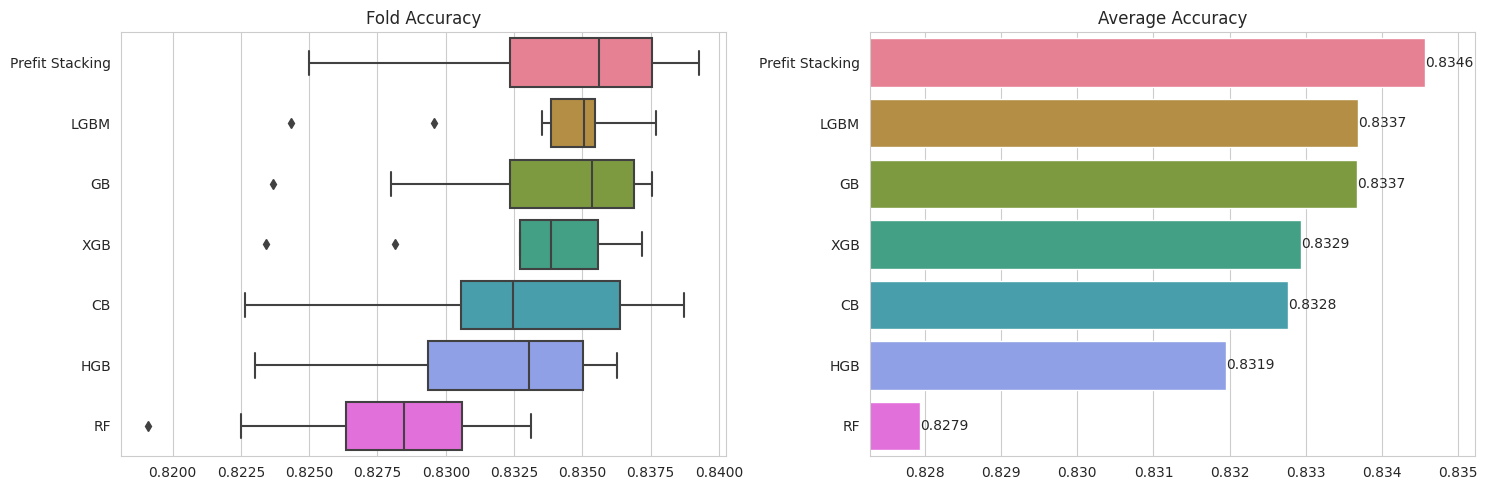

In [19]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

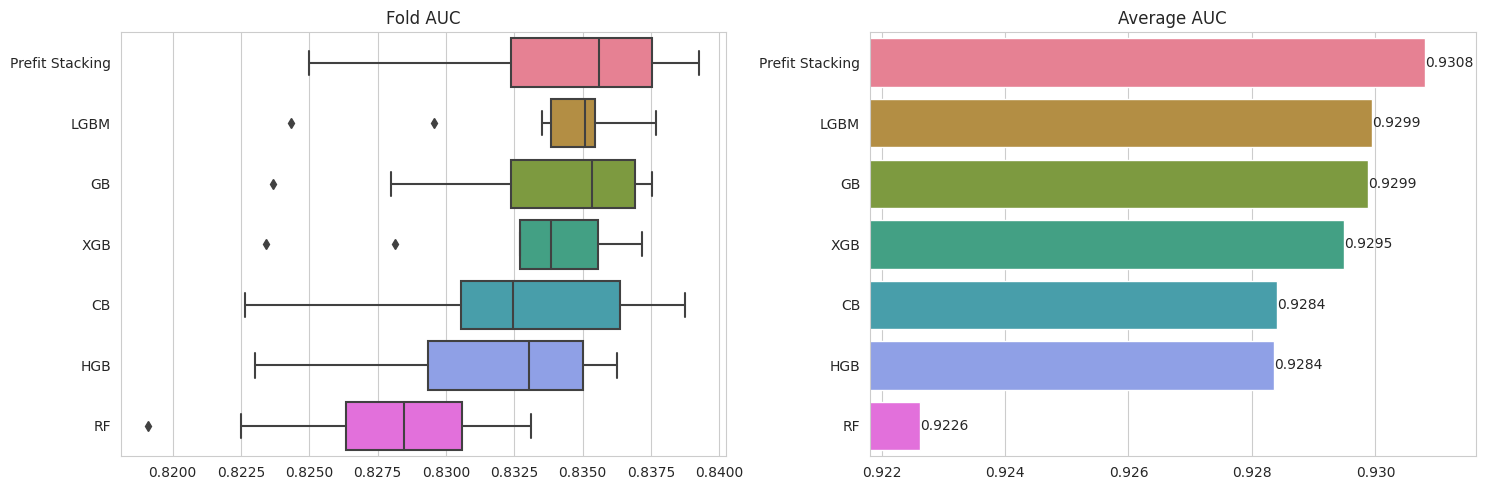

In [20]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

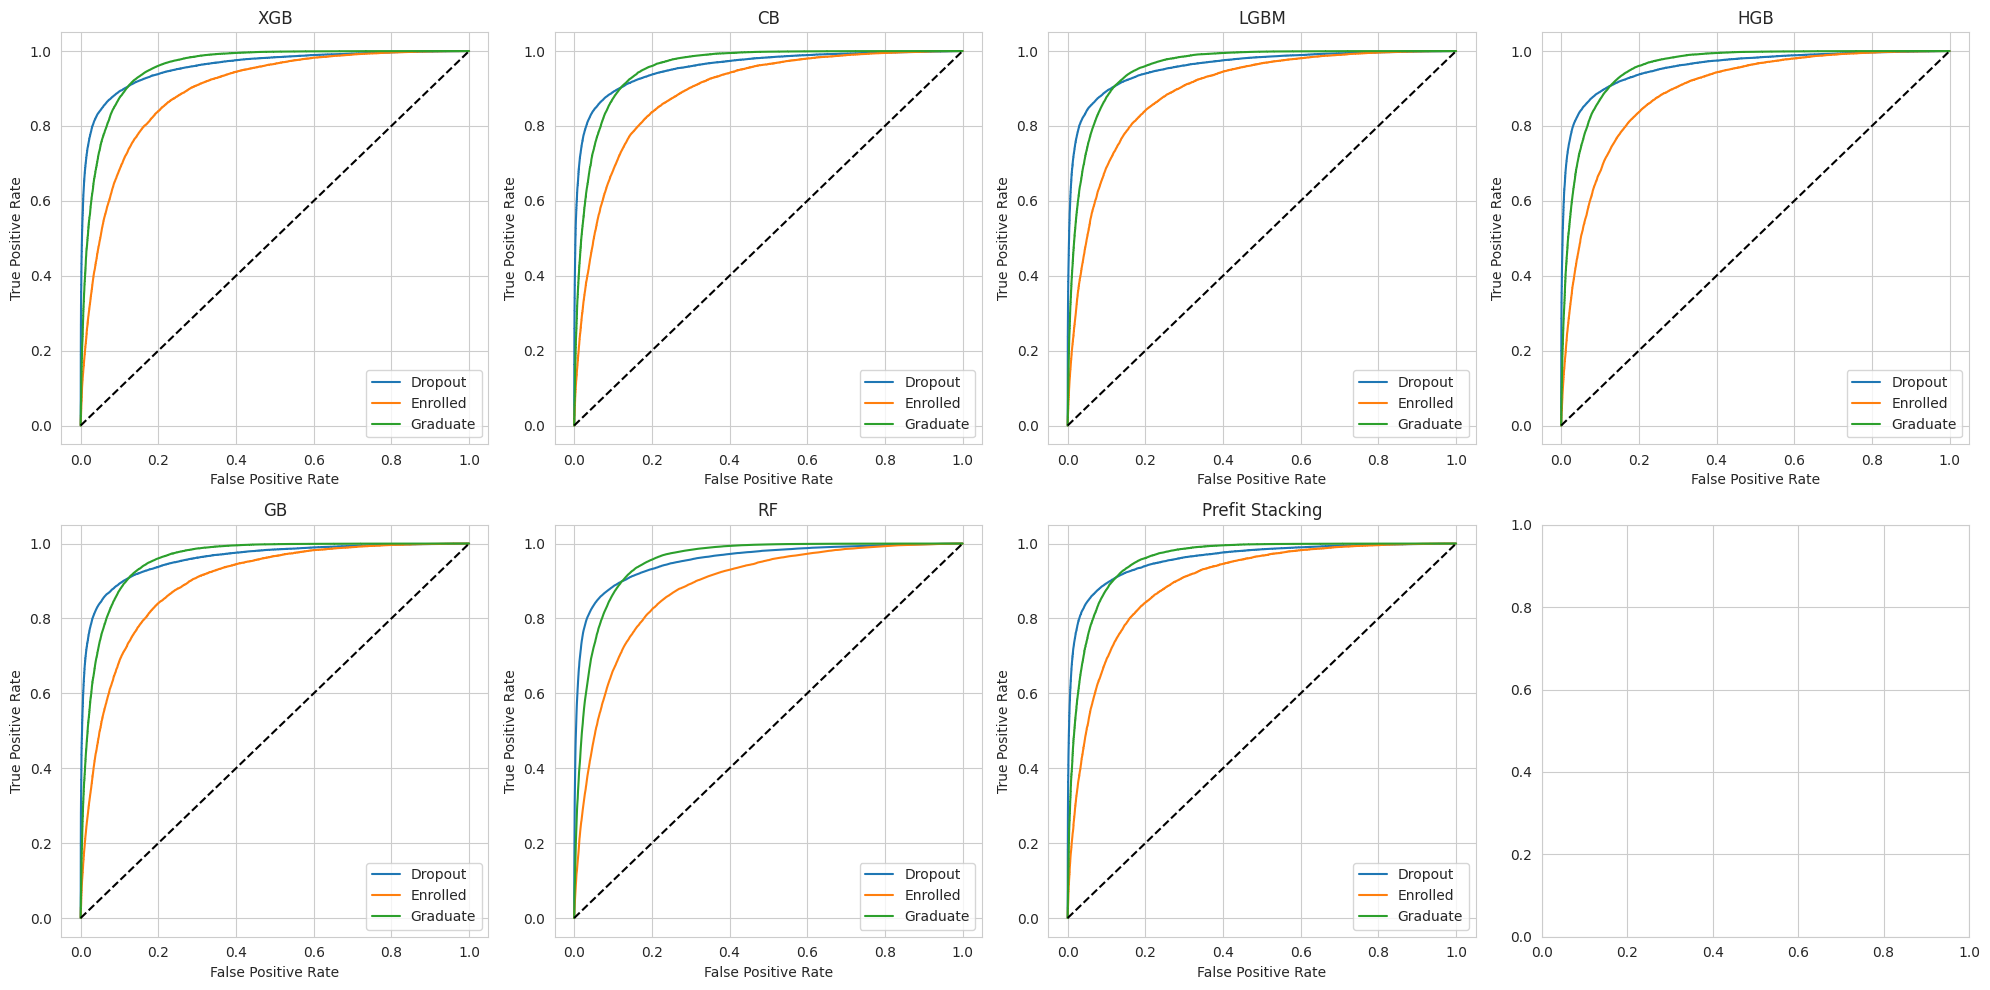

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    for i in range(pred_probs.shape[1]):
        fpr, tpr, _ = roc_curve(y, pred_probs[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')
        
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()

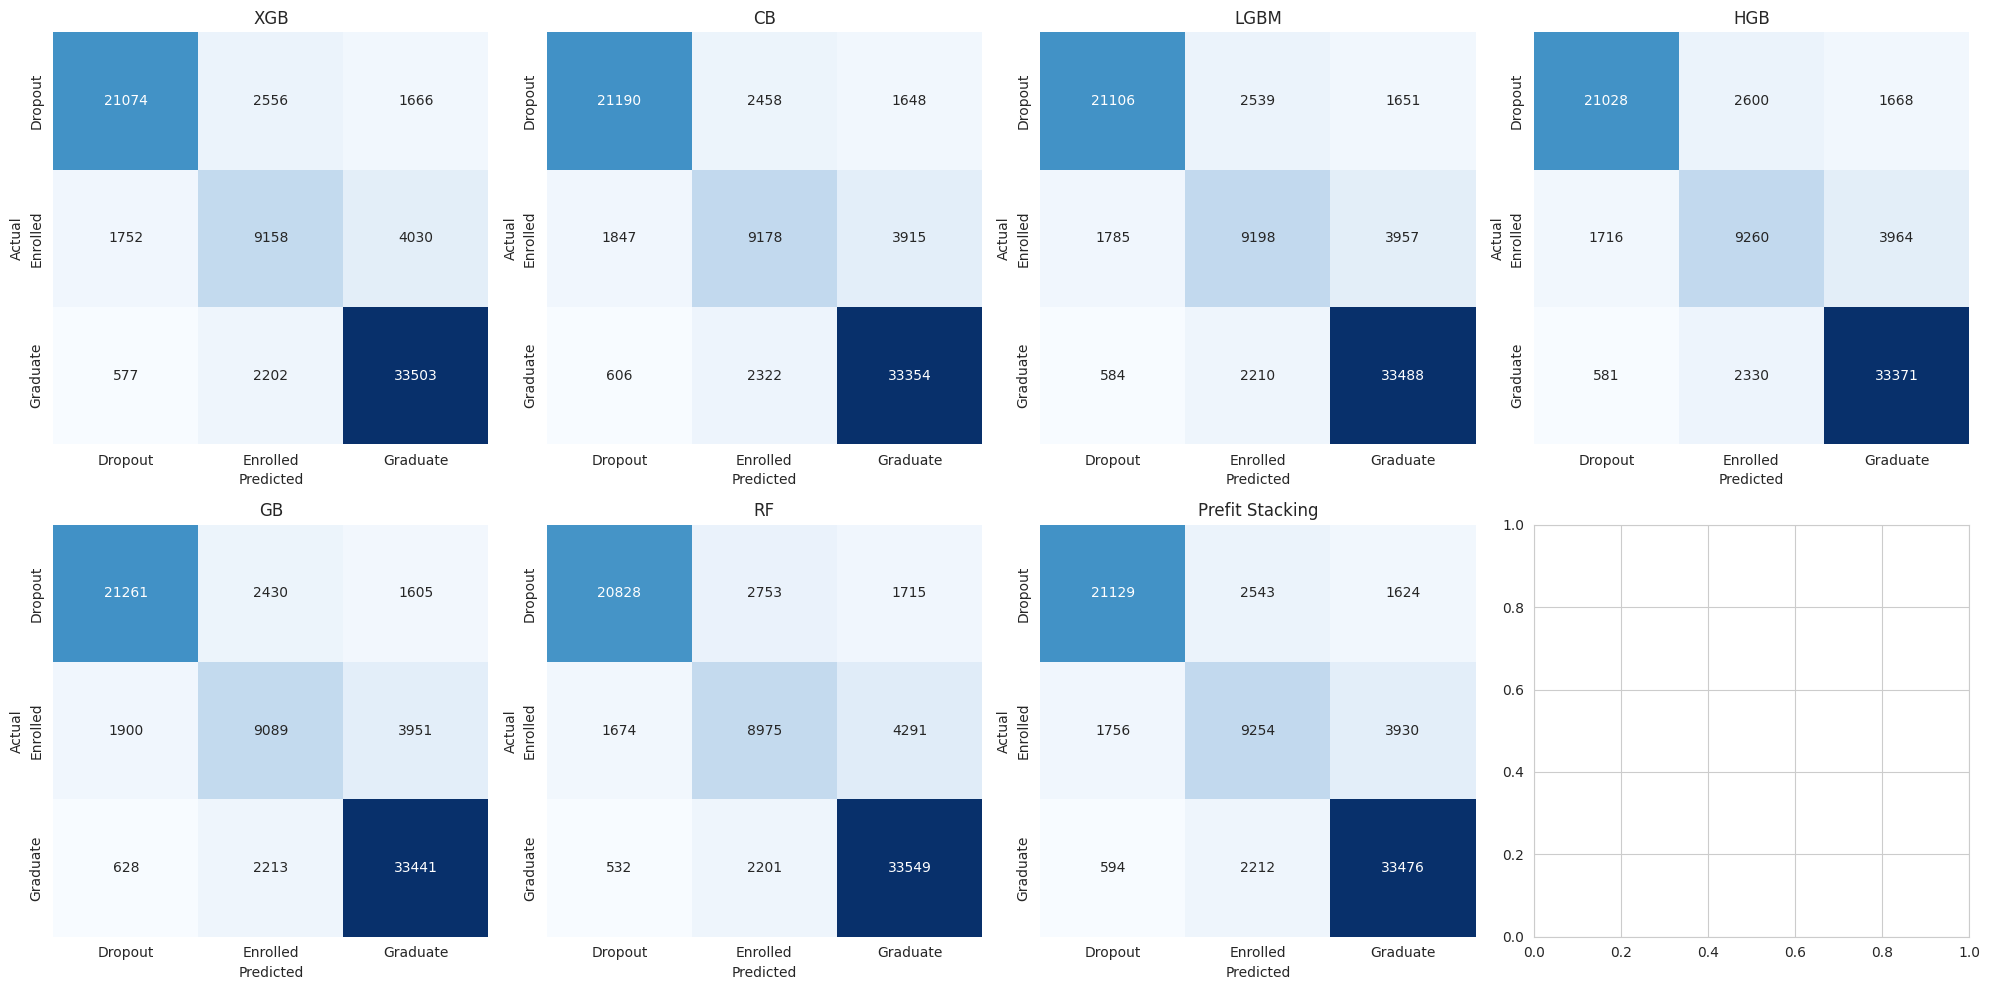

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    y_pred = np.argmax(pred_probs, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        cmap='Blues',
        ax=ax, 
        xticklabels=label_encoder.classes_, 
        yticklabels=label_encoder.classes_, 
        cbar=False,
        fmt='d'
    )
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Post-Processing and Creating a Submission File

In [23]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submission['Target'] = np.argmax(test_pred_probs['Prefit Stacking'], axis=1)
submission['Target'] = label_encoder.inverse_transform(submission['Target'])
submission.to_csv(f'prefit_stacking_acc-{mean_accs["Prefit Stacking"]:.6f}_auc-{mean_aucs["Prefit Stacking"]:.6f}.csv', index=False)
submission.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled


In [24]:
# submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
# submission['Target'] = np.argmax(test_pred_probs['Stacking'], axis=1)
# submission['Target'] = label_encoder.inverse_transform(submission['Target'])
# submission.to_csv(f'stacking_acc-{mean_accs["Stacking"]:.6f}_auc-{mean_aucs["Stacking"]:.6f}.csv', index=False)
# submission.head()

In [25]:
os.mkdir('oof_pred_probs')
os.mkdir('test_pred_probs')

for model, pred_probs in oof_pred_probs.items():
    with open(f'oof_pred_probs/{model.lower()}_oof_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)
        
for model, pred_probs in test_pred_probs.items():
    with open(f'test_pred_probs/{model.lower()}_test_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

In [26]:
shutil.rmtree("catboost_info")